In [136]:
import os
import numpy as np
import matplotlib as mpl
import cv2 as cv
from numpy import random as rand
from scipy import stats
from matplotlib import pyplot as plt, patches as patch
from skimage import measure as meas, segmentation as seg, color as col, \
                    filters as filt, morphology as morph, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [31]:
jtplot.reset()
# mpl.use('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [138]:
class VideoToGraph:
    
    def __init__(self, filename):
        self.filename = filename
        self.frame_store = []
        self.fname = filename[:-4]
        self.fps = 59.94
    
    def trackObject(self):
        frame_store = self.frame_store
        filename = self.filename
        
        cap = cv.VideoCapture(filename)
        ret, frame1 = cap.read()
        prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[...,1] = 255
        while(1):
            ret, frame2 = cap.read()
            if not ret:
                break
            next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
            flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
            frame_store.append(mag)
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
            bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
            cv.imshow('frame2',bgr)
            k = cv.waitKey(30) & 0xff
            if k == 27:
                break
            elif k == ord('s'):
                cv.imwrite('opticalfb.png',frame2)
                cv.imwrite('opticalhsv.png',bgr)
            prvs = next
        cap.release()
        cv.destroyAllWindows()
        self.frame_store = frame_store
    
    def plotObject(self):
        frame_store = self.frame_store
        fps = self.fps
        fname = self.fname
        
        x_avg = []
        for i in range(len(frame_store)):
            x_avg.append(np.argmax(frame_store[i].mean(axis=0)))

        t = np.linspace(0, len(frame_store)/fps, len(frame_store))
        x_avg = np.array(x_avg) * 1e-2
        grad_px = np.array([331.79, 336.16, 305.22, 334.69, 326,80]).mean() * 1e-2
        grad_cm = np.array([11.70, 11.86, 10.77, 11.81, 11.53]).mean() * 1e-2
        s_img = x_avg * grad_cm / grad_px

        dt = t[1] - t[0]
        v_avg = np.zeros_like(s_img)
        for i in range(1, len(s_img)):
            v_avg[1:] = np.diff(s_img)/dt

        fig, (ax1, ax2) = mp.subplots(2, 1, sharex=True)

        ax1.plot(t, s_img, "bo")
        ax1.set_ylabel("Displacement, m")
        ax1.set_title("_".join(fname.split("_")[0:1]) + " " + "_".join(fname.split("_")[1:]))
        ax1.grid(True)
        posname = fname + "_pos.txt"
        np.savetxt(posname, np.array([t, s_img]))

        ax2.plot(t, v_avg, "go")
        ax2.set_xlabel("Time, s")
        ax2.set_ylabel("Velocity, m/s")
        ax2.grid(True)
        velname = fname + "_vel.txt"
        np.savetxt(velname, np.array([t, v_avg]))

        sname = fname + ".png"
        mp.savefig(sname, bbox_inches="tight", dpi=300)
        mp.show()
        
    def run(self):
        self.trackObject()
        self.plotObject()

In [146]:
filenames = os.listdir()
for f in filenames:
    if f.endswith('.avi'):
        fn = f[:-4] + '/'
        vid = VideoToGraph(f)
        vid.trackObject()
        for i,v in enumerate(vid.frame_store):
            cv.imwrite(fn + str(i) + '.png', v)

In [203]:
parent_dir = 'castor_28g'
filenames = os.listdir('%s/'%parent_dir)
x_coords = []
for n, f in enumerate(filenames):
    frame = cv.imread('%s/%s.png'%(parent_dir, str(n)), 0)
    thresh, frame = cv.threshold(frame, 127, 255, cv.THRESH_OTSU)
    labeled = meas.label(frame)
    props = meas.regionprops(labeled)
    x_coords.append(props[0]['centroid'][1])

In [204]:
fps = 15
t = np.linspace(0, len(x_coords)/fps, len(x_coords))
x_coords = np.array(x_coords) * 1e-2
grad_px = np.array([331.79, 336.16, 305.22, 334.69, 326,80]).mean() * 1e-2
grad_cm = np.array([11.70, 11.86, 10.77, 11.81, 11.53]).mean() * 1e-2
s_img = x_coords * grad_cm / grad_px

dt = t[1] - t[0]
v_avg = np.zeros_like(s_img)
v_avg[1:] = np.diff(s_img)/dt

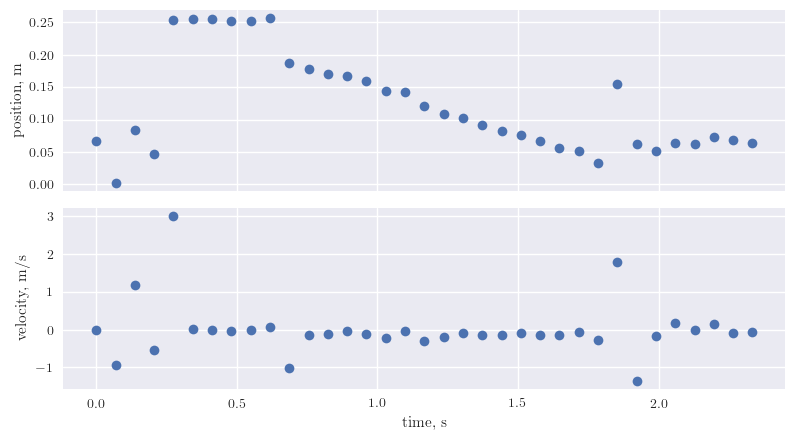

In [222]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16/2, 9/2))

ax[0].plot(t, s_img, 'o')
ax[0].set_ylabel('position, m')

ax[1].plot(t, v_avg, 'o')
ax[1].set_xlabel('time, s')
ax[1].set_ylabel('velocity, m/s')

plt.tight_layout()
plt.show()